#  <font color='#FFE15D'><b>💎 Project 4: Speech Recognition 🎙️</b></font>
<img src="http://dl.howsam.org/Deep-Catalyst/rocket-200px.png" alt="Deep Catalyst"/>

Deep Catalyst Course [webpage](https://howsam.org/downloads/deep-catalyst/)

by Howsam AI Academy (www.howsam.org)

# 🔴 **Environment Setup**

## 🟠 The command for connecting Colab to the local host (PC or laptop) is as follows:

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0`

## 🟠 Perhaps you may need to install the `torchmetrics` library. To do so, you can execute this cell.

In [ ]:
!pip install -q torchmetrics

## 🟠 Install `portalocker`

In [ ]:
!pip install -q portalocker>=2.0.0

## 🟠 Install `wandb`

In [ ]:
!pip install wandb

# ⚠️ **Don't forget to restart the runtime!**

# 🔴 **Import Libs**

In [ ]:
import os
import sys
import time
import math
import random
import tqdm
from glob import glob
from typing import Any, Callable, Dict, List, Optional, Tuple
from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim

import torchvision
from torchvision import models

import torchaudio
import torchaudio.transforms as T

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torchmetrics as tm
from torchmetrics.aggregation import MeanMetric
from torchmetrics.text import WordErrorRate as WER

In [ ]:
!python --version

Python 3.11.5


In [ ]:
for lib in [np, torch, torchaudio, torchtext, tm, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.0
torch --> 2.1.0
torchaudio --> 2.1.0
torchtext --> 0.16.0
torchmetrics --> 1.2.0
tqdm --> 4.65.0


# 🔴 **Utils**

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


In [ ]:
def time_for_each_batch(loader):
  start = time.time()
  for iter, (img, mask) in enumerate(loader, 1):
    continue
  end = time.time()
  total_time = end - start
  return total_time, total_time/len(loader)

In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

# 🔴 **Arguments**

In [ ]:
seed = 8
wandb_enable = False
root = 'data/LJSpeech-1.1'
batch_size = 32
sample_rate = 22050
clip = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.1
momentum = 0.9
wd = 1e-4
num_epochs = 20

In [ ]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


# 🔴 **Dataset**

## 🟠 Load the Dataset

In [ ]:
df = pd.read_csv(f'{root}/metadata.csv', delimiter='|', header=None)
df.head()

In [ ]:
item = random.randint(0, df.shape[0])
wav_id, txt, normz_txt = df.iloc[item]
print(wav_id, txt, normz_txt, sep='\n', end='\n\n')

waveform, sample_rate = torchaudio.load(f'{root}/wavs/{wav_id}.wav')
print(waveform.shape, waveform.dtype, sample_rate, sep='\n', end='\n\n')

Audio(data=waveform, rate=sample_rate)

## 🟠 Dataset preparation

### 🟡 Load CSV file


In [ ]:
df = pd.read_csv(f'{root}/metadata.csv', delimiter='|', names=['id', 'transcript', 'normalized_transcript'])
df.head()

In [ ]:
df.describe()

### 🟡 Find NaN values


In [ ]:
df[df.normalized_transcript.isna()].transcript[945]

In [ ]:
df.iloc[929].transcript

In [ ]:
df = pd.read_csv(f'{root}/metadata.csv',
                 delimiter='|', names=['id', 'transcript', 'normalized_transcript'],
                 quoting=3)
df.head()

In [ ]:
df.describe()

In [ ]:
df.iloc[929].transcript
df.iloc[945].normalized_transcript

### 🟡 Find duplicate rows


In [ ]:
duplicates = df[df.transcript.duplicated(keep=False)].reset_index()
duplicates

In [ ]:
sample_temp = duplicates.iloc[12]
print(sample_temp.transcript, end='\n\n')

waveform, sample_rate = torchaudio.load(f'{root}/wavs/{sample_temp.id}.wav')
Audio(data=waveform, rate=sample_rate)

### 🟡 Add path audio files to the dataframe


In [ ]:
df['path'] = df['id'].apply(lambda x: f'{root}/wavs/{x}.wav')
df.head()

In [ ]:
item = random.randint(0, df.shape[0])
wav_id, txt, normz_txt, path = df.iloc[item]
print(wav_id, txt, normz_txt, sep='\n', end='\n\n')

waveform, sample_rate = torchaudio.load(path)
print(waveform.shape, waveform.dtype, sample_rate, sep='\n', end='\n\n')

Audio(data=waveform, rate=sample_rate)

In [ ]:
df = df[['id', 'path', 'transcript', 'normalized_transcript']]
df.head()

### 🟡 Create train, validation, and test subsets from the dataset


In [ ]:
generator = torch.Generator().manual_seed(seed)
train, valid, test = random_split(df, lengths=[0.75, 0.10, 0.15], generator=generator)

In [ ]:
# valid.dataset
len(train.indices), len(valid.indices), len(test.indices)

#### ⚪ Train

In [ ]:
df_train = df.iloc[train.indices]
print(df_train.shape)
df_train.to_csv(f'{root}/train-subset.csv', index=False)

#### ⚪ Validation

In [ ]:
df_valid = df.iloc[valid.indices]
print(df_valid.shape)
df_valid.to_csv(f'{root}/valid-subset.csv', index=False)

#### ⚪ Test

In [ ]:
df_test = df.iloc[test.indices]
print(df_test.shape)
df_test.to_csv(f'{root}/test-subset.csv', index=False)

### 🟡 Build a vocab


In [ ]:
df_train = pd.read_csv('data/LJSpeech-1.1/train-subset.csv')
df_train.head()

In [ ]:
print(set(list(''.join(df_train.normalized_transcript.to_list()))))

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
vocab = build_vocab_from_iterator(df_train.normalized_transcript.apply(lambda x: x.lower()),
                                  min_freq=10,
                                  specials=['=', '#', '<', '>'], special_first=True)
vocab.set_default_index(1)
print(vocab.get_itos())

In [ ]:
len(sorted(vocab.get_itos()))

In [ ]:
torch.save(vocab, 'vocab.pt')

## 🟠 EDA

In [ ]:
df_train = pd.read_csv('data/LJSpeech-1.1/train-subset.csv')

### 🟡 Identify characteristics of audio files within the dataset


In [ ]:
idx = random.randint(0, len(df_train))
sample = df_train.iloc[idx]

_, sample_rate = torchaudio.load(sample['path'])
print(sample_rate)

### 🟡 Plot the audio files


In [ ]:
idx = random.randint(0, len(df_train))
sample = df_train.iloc[idx]

waveform, sample_rate = torchaudio.load(sample['path'])

plt.plot(waveform[0])
print(sample['normalized_transcript'])
Audio(data=waveform, rate=sample_rate)

In [ ]:
plot_waveform(waveform, sample_rate)

### 🟡 Plot the spectrogram of audio files


In [ ]:
idx = random.randint(0, len(df_train))
sample = df_train.iloc[idx]
waveform, sample_rate = torchaudio.load(sample['path'])

spec = T.MelSpectrogram(sample_rate=sample_rate, n_mels=224)
spec(waveform).shape

In [ ]:
plot_specgram(waveform, sample_rate)

### 🟡 Compare the `MelSpectrogram` on CPU & GPU

In [ ]:
transform = T.MelSpectrogram(sample_rate=sample_rate).to(device)
transform(waveform.repeat(10, 1, 1).to(device)).shape

In [ ]:
sample = df_train.iloc[0]
waveform, sample_rate = torchaudio.load(sample['path'])
waveform = waveform.repeat(100, 1, 1)
print(waveform.shape)

transform = T.MelSpectrogram(sample_rate=sample_rate).requires_grad_(False)

n = 100
s = time.time()

for i in range(n):
  with torch.no_grad():
    mel_specgram = transform(waveform)

print(1e3*(time.time() - s)/n)

print(mel_specgram.shape)

In [ ]:
sample = df_train.iloc[0]
waveform, sample_rate = torchaudio.load(sample['path'])
waveform = waveform.repeat(100, 1, 1).to(device)
print(waveform.shape)

transform = T.MelSpectrogram(sample_rate=sample_rate).requires_grad_(False).to(device)

n = 100
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for i in range(n):
  with torch.no_grad():
    mel_specgram = transform(waveform)

end.record()
torch.cuda.synchronize()

print(start.elapsed_time(end)/n)

print(mel_specgram.shape)

### 🟡 Calculate the time spent loading an audio file


In [ ]:
total_nbytes = 0

start = time.time()

for path in df_train['path']:
  waveform, sample_rate = torchaudio.load(path)

end = time.time()

print(f'{end-start:.2f}s', f"{1e3*(end-start)/len(df_train['path']):.2f} ms")

### 🟡 Calculate the total RAM occupation by dataset


In [ ]:
total_nbytes = 0

for path in df_train['path']:
  waveform, _ = torchaudio.load(path)
  total_nbytes += waveform.nbytes

print(f'{total_nbytes/1e6} GB')

## 🟠 Custom dataset

In [ ]:
class LJSpeechDataset(Dataset):

  def __init__(self, root: str, csv_file: str,
               transform: Optional[Callable] = None,
               target_transform: Optional[Callable] = None,
               memory: Optional[bool] = False):

    self.data = pd.read_csv(os.path.join(root, csv_file))

    self.phase = csv_file.split('-')[0].capitalize()
    self.transform = transform
    self.target_transform = target_transform
    self.memory = memory

    self.sos = target_transform(['<'])
    self.eos = target_transform(['>'])

    if memory:
      self._save_memory()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if self.memory:
      waveform = self.audios[idx].clone().squeeze()
    else:
      waveform = torchaudio.load(self.data.iloc[idx, 1])[0].squeeze()

    transcript = self.data.iloc[idx, 3]

    transcript = self.target_transform(list(transcript.lower()))
    transcript = self.sos + transcript + self.eos
    transcript = torch.LongTensor(transcript)

    return waveform, transcript

  def _save_memory(self):
    self.audios = []
    for path in self.data['path']:
      self.audios.append(self._load_audio(path))

  def _load_audio(self, path):
    return torchaudio.load(path)[0]

  def __repr__(self):
    return f"""Number of Datapoints: {len(self.data)}\nPhase: {self.phase}"""


In [ ]:
vocab = torch.load('vocab.pt')
train_set = LJSpeechDataset(root=root, csv_file='train-subset.csv',
                            target_transform=vocab)
train_set, train_set[4]

#### ⚪ Final

In [ ]:
vocab = torch.load('vocab.pt')

train_set = LJSpeechDataset(root=root, csv_file='train-subset.csv', target_transform=vocab, memory=True)

valid_set = LJSpeechDataset(root=root, csv_file='valid-subset.csv', target_transform=vocab, memory=True)

test_set = LJSpeechDataset(root=root, csv_file='test-subset.csv', target_transform=vocab, memory=False)

In [ ]:
train_set[4]

## 🟠 Dataloader

In [ ]:
def collate_fn(batch):
  x, y = zip(*batch)
  x = torch.nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=0).unsqueeze(1)
  y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0)
  return x, y

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
waveforms, targets = next(iter(train_loader))
waveforms.shape, targets.shape

(torch.Size([32, 1, 222621]), torch.Size([32, 165]))

In [ ]:
targets[0]

#### ⚪ Time per batch

In [ ]:
time_for_each_batch(test_loader)

In [ ]:
time_for_each_batch(valid_loader)

In [ ]:
time_for_each_batch(train_loader)

# 🔴 **Model**

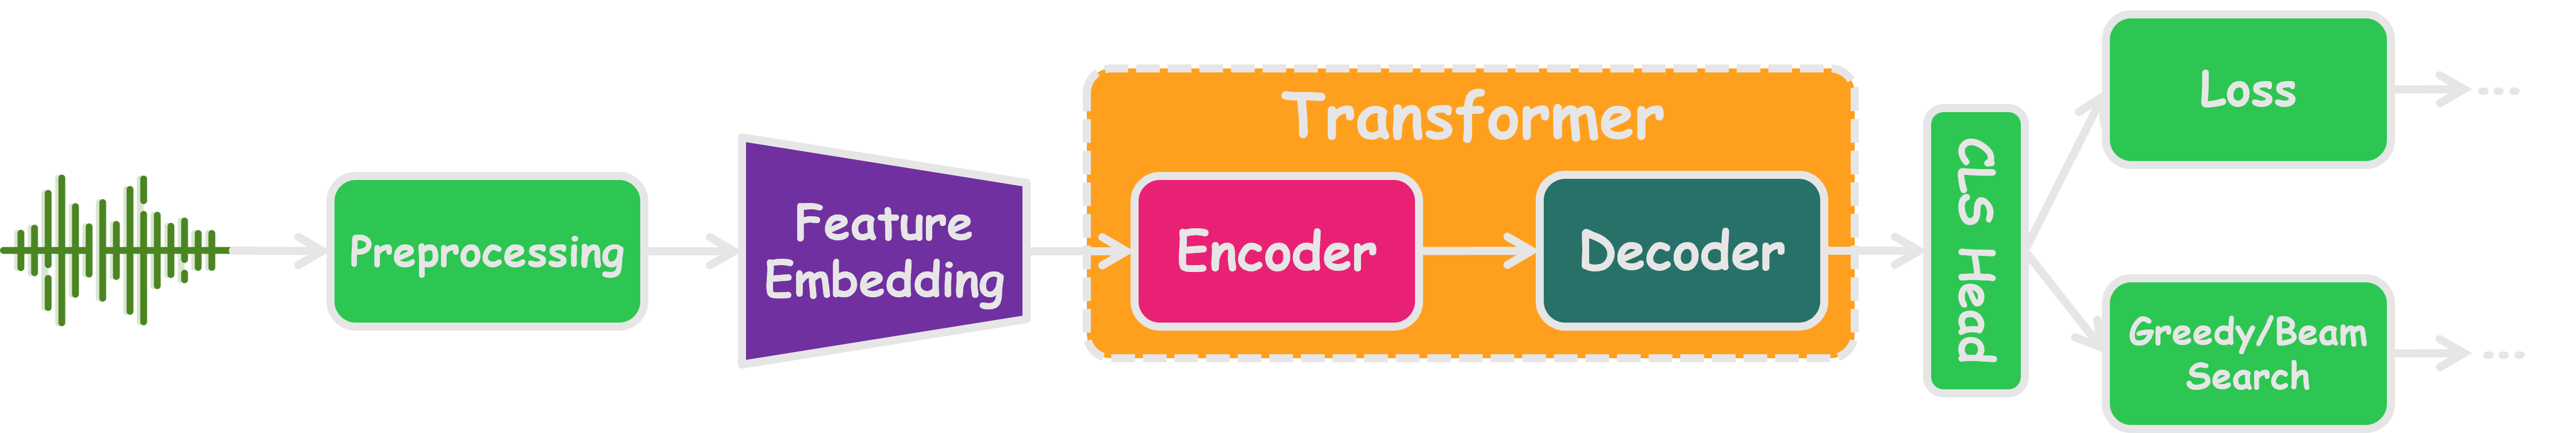

## 🟠 CNN Feature Embedding

### 🟡 Simple CNN Model

In [ ]:
class CNN2DFeatureExtractor(nn.Module):

  def __init__(self, inplanes, planes):
    super().__init__()

    self.conv1 = nn.Conv2d(1, inplanes, kernel_size=11, stride=1, padding=5, bias=False)
    self.bn1 = nn.BatchNorm2d(inplanes)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.conv2 = nn.Conv2d(inplanes, planes, kernel_size=11, stride=1, padding=5, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.conv3 = nn.Conv2d(planes, planes, kernel_size=11, stride=1, padding=5, bias=False)
    self.bn3 = nn.BatchNorm2d(planes)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=(2, 1), padding=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)

    x = self.maxpool2(x)

    return x

In [ ]:
model = CNN2DFeatureExtractor(inplanes=32, planes=64)

with torch.no_grad():
  out = model(torch.randn(32, 1, 80, 796))
out.shape

### 🟡 ResNet-based Model

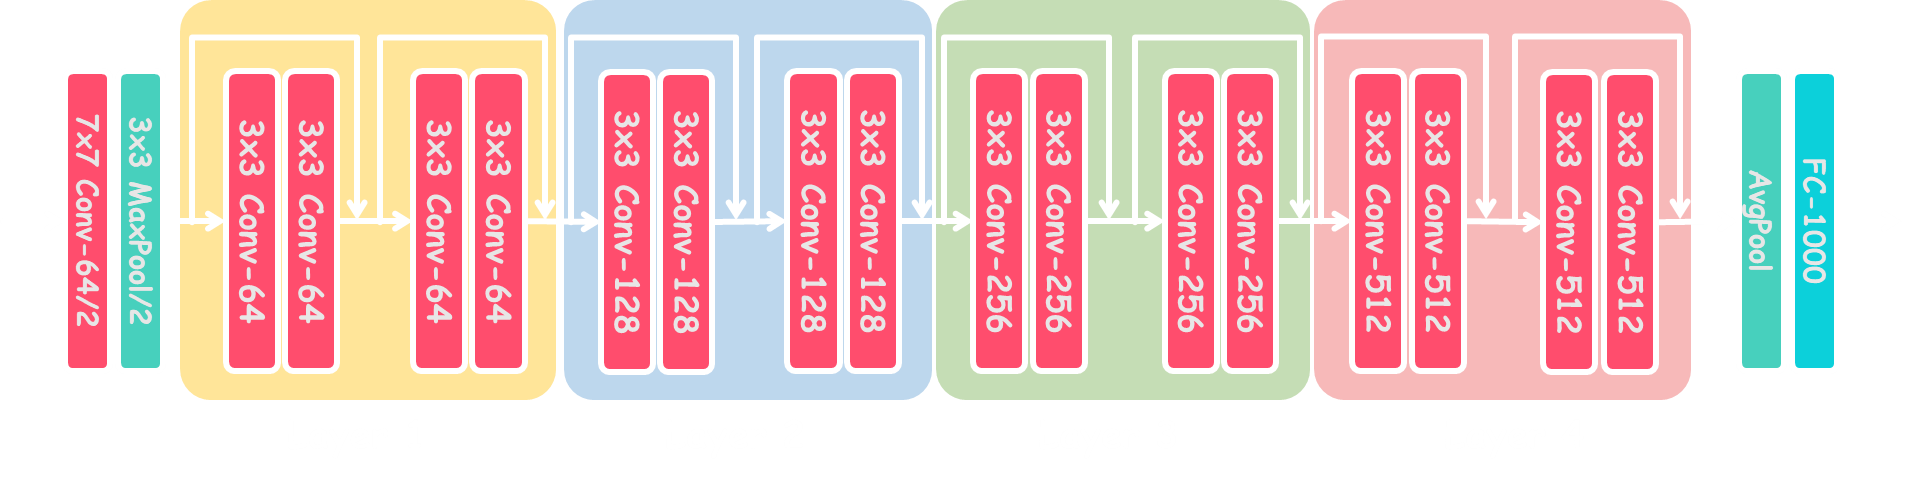

In [ ]:
model = models.resnet18().to(device)
# model.avgpool = nn.Identity()
# model.fc = nn.Identity()
temp_list = list(model.children())
model = nn.Sequential(*temp_list[0:-5]).to(device)

with torch.no_grad():
  out = model(torch.randn((2, 3, 80, 796), device=device))
out.shape

In [ ]:
del out, temp_list, model

In [ ]:
class ResNetFeatureExtractor(nn.Module):

  def __init__(self, ):
    super().__init__()

    self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    module_list = list(self.model.children())[:-5]
    self.model = nn.Sequential(*module_list)

  def forward(self, src):
    src = self.model(src)
    return src

In [ ]:
model = ResNetFeatureExtractor().to(device)
with torch.no_grad():
  out = model(torch.randn((2, 3, 80, 796), device=device))
out.shape

torch.Size([2, 64, 20, 199])

In [ ]:
from torchvision.models.resnet import BasicBlock
BasicBlock(inplanes=32, planes=64, )

In [ ]:
class ResNetFeatureExtractor2(nn.Module):

  def __init__(self, ):
    super().__init__()

    self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    module_list = [nn.Conv2d(1, 64, 7, stride=(2, 1), padding=3, bias=False)]
    module_list += list(self.model.children())[1:-5]
    module_list += [nn.Conv2d(64, 32, 1, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True)]
    self.model = nn.Sequential(*module_list)

  def forward(self, src):
    src = self.model(src)
    return src

In [ ]:
model = ResNetFeatureExtractor2().to(device)
with torch.no_grad():
  out = model(torch.randn((2, 1, 80, 800), device=device))
out.shape

torch.Size([2, 32, 20, 400])

In [ ]:
model

ResNetFeatureExtractor2(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

## 🟠 Transformer

### 🟡 Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
    Arguments:
        x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
    """
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)

In [ ]:
pos_encoding = PositionalEncoding(d_model=128, )
print(pos_encoding.pe.shape)

pos_encoding(torch.randn(200, 2, 128)).shape

### 🟡 Transformer Model

In [ ]:
class TransformerModel(nn.Module):

  def __init__(self, d_model, nhead, num_encoders, num_decoders, dim_feedforward,
               dropout=0.1, activation=F.relu):
    super().__init__()

    self.d_model = d_model

    # Embedding
    self.embedding = nn.Embedding(len(vocab), embedding_dim=d_model, padding_idx=0)

    # Position Encoding
    self.pos_encoder = PositionalEncoding(d_model=d_model)

    # Transformer
    self.transformer = nn.Transformer(
        d_model=d_model, nhead=nhead,
        num_encoder_layers=num_encoders, num_decoder_layers=num_decoders,
        dim_feedforward=dim_feedforward,
        dropout=dropout, activation=activation
        )

    self.init_weights()

  def init_weights(self) -> None:
      initrange = 0.1
      self.embedding.weight.data.uniform_(-initrange, initrange)

  def forward(self, src, tgt):
    tgt = self.embedding(tgt) * math.sqrt(self.d_model)

    tgt = tgt.permute(1, 0, 2)
    tgt = self.pos_encoder(tgt)

    tgt_mask = nn.Transformer.generate_square_subsequent_mask(len(tgt)).to(device)
    out = self.transformer(src, tgt, tgt_mask=tgt_mask)

    return out

In [ ]:
model = TransformerModel(d_model=128, nhead=4, num_encoders=4, num_decoders=1,
                         dim_feedforward=128, )
with torch.no_grad():
  out = model(src=torch.randn(50, 32, 128), tgt=targets)
out.shape

## 🟠 Speech Recognition Model

In [ ]:
class SpeechRecognitionModel(nn.Module):

  def __init__(self,
               d_model, nhead, num_encoders, num_decoders, dim_feedforward, dropout=0.1, activation=F.relu,
               cnn_mode='simple', inplanes=32, planes=64,
               n_mels=128, n_fft=400):
    super().__init__()

    # Transform
    self.transforms = nn.Sequential(
        T.Resample(orig_freq=sample_rate, new_freq=16000),
        T.MelSpectrogram(n_mels=n_mels, n_fft=n_fft),
        # T.FrequencyMasking()
        ).requires_grad_(False)

    # Feature embedding
    self.cnn_mode = cnn_mode
    if cnn_mode == 'simple':
      self.cnn = CNN2DFeatureExtractor(inplanes=inplanes, planes=planes)
    elif cnn_mode == 'resnet':
      self.cnn = ResNetFeatureExtractor()
    else:
      raise NotImplementedError("Please select one of the simple or resnet model")

    # Transformer
    self.transformers = TransformerModel(
        d_model=d_model, nhead=nhead,
        num_encoders=num_encoders, num_decoders= num_decoders,
        dim_feedforward=dim_feedforward, dropout=dropout, activation=activation)

    # Classifier
    self.cls = nn.Linear(d_model, len(vocab))

    self.init_weights()

  def init_weights(self) -> None:
    initrange = 0.1
    self.cls.bias.data.zero_()
    self.cls.weight.data.uniform_(-initrange, initrange)

  def forward(self, src, tgt):
    with torch.no_grad():
      src = self.transforms(src)

    if self.cnn_mode == 'resnet':
      src = src.repeat(1, 3, 1, 1)
    src = self.cnn(src)

    batch_size, num_channels, freq_bins, seq_len = src.shape
    src = src.reshape(batch_size, -1, seq_len)
    src = src.permute(2, 0, 1)

    out = self.transformers(src, tgt)
    out = out.permute(1, 0, 2)

    out = self.cls(out)

    return out

In [ ]:
model = SpeechRecognitionModel(
    d_model=640, nhead=4, num_encoders=4, num_decoders=1, dim_feedforward=640*2,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    )
# model

In [ ]:
with torch.no_grad():
  out = model(waveforms, targets)
out.shape

In [ ]:
# plot_spectrogram(out[0, 0])
# Audio(data=waveforms[0], rate=sample_rate)

## 🟠 Final

In [ ]:
n_mels = ?
cnn_output = ? 4-d

bs x 1 x L --> bs x 1 x nm x l --> bs x c x (nm/sh) x (l/sw)

bs x c x (nm/sh) x (l/sw) --> bs x (c*nm/sh) x (l/sw) --> (l/sw) x bs x (c*nm/sh)

(l/sw) x bs x (c*nm/sh) --> L x BS x F

(l/2) x bs x (32*80/4)

In [ ]:
model = SpeechRecognitionModel(
    d_model=640, nhead=4, num_encoders=4, num_decoders=1, dim_feedforward=640,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    )
# model

C:\Users\PC\anaconda3\envs\torchv2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
num_trainable_params(model)

14.270474

In [ ]:
with torch.no_grad():
  outputs = model(waveforms, targets)
outputs.shape

torch.Size([32, 160, 42])

# 🔴 **Config**

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
outputs.shape, targets.shape

(torch.Size([32, 160, 42]), torch.Size([32, 160]))

In [ ]:
loss_fn(outputs.permute(0, 2, 1), targets)

tensor(4.7468)

In [ ]:
waveforms.shape, targets.shape

(torch.Size([32, 1, 220573]), torch.Size([32, 160]))

In [ ]:
with torch.no_grad():
  outputs = model(waveforms, targets[:, :-1])
outputs.shape

torch.Size([32, 159, 42])

In [ ]:
loss_fn(outputs.permute(0, 2, 1), targets[:, 1:])

tensor(4.8741)

In [ ]:
metric = WER().to(device)

In [ ]:
if wandb_enable:
    key_file = '/content/key'

    if os.path.exists(key_file):
        with open(key_file) as f:
            key = f.readline().strip()
        wandb.login(key=key)
    else:
        print("Key file does not exist. Please create the key file with your wandb API key.")

# 🔴 **Functions**

In [ ]:
def postprocess(outputs, targets):
  generates, transcripts = [], []
  for output, target in zip(outputs, targets):
    # Generates
    g = ''.join(vocab.lookup_tokens(output.argmax(dim=-1).tolist()))
    generates.append(g)
    # Transcripts
    t = ''.join(vocab.lookup_tokens(target.tolist()))
    transcripts.append(t)
  return generates, transcripts

In [ ]:
generates, transcripts = postprocess(outputs, targets)
len(generates), len(transcripts)

(32, 32)

In [ ]:
metric_temp = WER().to(device)
metric_temp(generates, transcripts)

tensor(1., device='cuda:0')

In [ ]:
outputs.shape, targets.shape

(torch.Size([32, 160, 42]), torch.Size([32, 160]))

In [ ]:
print(''.join(vocab.lookup_tokens(targets[0].tolist())))

<from the shipping room of the depository and forwarded it to the fbi laboratory in washington.>================================================================


In [ ]:
print(''.join(vocab.lookup_tokens(outputs[0].argmax(dim=-1).tolist())))

"gx",i""!fe?>ci>f"tcm?!km)i"c?f""i?e""mc"kf"""t(x!fpc?mf>"f"(f""?x?f>k"fc?cf.ic"t>xfcg?c!fp"?fg?fk,==f=!ff=f=kf'=!f=ffk!f=k=ff!ff=f!==ff=ff=fffffffff=fkfkffkf==


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, scheduler=None, epoch=None):
  model.train()
  loss_train = MeanMetric()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets[:, :-1])

      loss = loss_fn(outputs.permute(0, 2, 1), targets[:, 1:])

      loss.backward()
      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      if scheduler:
        scheduler.step()

      loss_train.update(loss.item(), weight=len(targets))

      outputs, targets = postprocess(outputs, targets)
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.compute().item(),
                         metric=metric.compute().item())

  return model, loss_train.compute().item(), metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = MeanMetric()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets[:, :-1])

      loss = loss_fn(outputs.permute(0, 2, 1), targets[:, 1:])
      loss_eval.update(loss.item(), weight=len(targets))

      outputs, targets = postprocess(outputs, targets)
      metric.update(outputs, targets)

  return loss_eval.compute().item(), metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = SpeechRecognitionModel(
    d_model=640, nhead=2, num_encoders=4, num_decoders=1, dim_feedforward=640,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    ).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs, targets)
  loss = loss_fn(outputs.permute(0, 2, 1), targets)

print(loss)

C:\Users\PC\anaconda3\envs\torchv2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor(4.4857, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
mini_train_size = 200
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20, shuffle=True, collate_fn=collate_fn)

In [ ]:
model = SpeechRecognitionModel(
    d_model=640, nhead=2, num_encoders=4, num_decoders=1, dim_feedforward=640,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

C:\Users\PC\anaconda3\envs\torchv2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
num_epochs = 200
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, None, epoch+1)

Epoch 200: 100%|██████████████████████████████████████████| 10/10 [00:02<00:00,  3.96batch/s, loss=0.259, metric=0.553]


In [ ]:
waveforms, targets = next(iter(mini_train_loader))
with torch.no_grad():
  outputs = model(waveforms.to(device), targets[:, :-1].to(device))
outputs, targets = postprocess(outputs, targets)

In [ ]:
outputs[1], targets[1]

('the detection of these toauds come while he was sehflypeominently before the world ws the lesseeeof the olympic.> rllaaeeeeeeeleeeeeelllellebl',
 '<the detection of these frauds came while he was still prominently before the world as the lessee of the olympic.>=============================')

In [ ]:
torch.cuda.empty_cache()

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 2

for lr in [1, 0.5, 0.1, 0.05, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')

  model = SpeechRecognitionModel(
    d_model=640, nhead=2, num_encoders=4, num_decoders=1, dim_feedforward=640,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    ).to(device)

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, valid_loader, loss_fn, optimizer, metric, None, epoch+1)

  print()

LR=1


C:\Users\PC\anaconda3\envs\torchv2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:16<00:00,  2.44batch/s, loss=45.3, metric=1.03]



LR=0.5


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:16<00:00,  2.44batch/s, loss=6.14, metric=1.15]



LR=0.1


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:16<00:00,  2.42batch/s, loss=2.56, metric=1.59]



LR=0.05


Epoch 2: 100%|███████████████████████████████████████████████| 41/41 [00:16<00:00,  2.44batch/s, loss=2.5, metric=1.96]



LR=0.01


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:17<00:00,  2.38batch/s, loss=2.56, metric=2.06]



LR=0.001


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:17<00:00,  2.40batch/s, loss=3.02, metric=1.84]



LR=0.0001


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:17<00:00,  2.40batch/s, loss=4.21, metric=1.12]

In [ ]:
torch.cuda.empty_cache()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs =

for lr in [...]:
  for wd in [...]:
    print(f'LR={lr}, WD={wd}')

    model =
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

In [ ]:
torch.cuda.empty_cache()

🔰 Define model.

In [ ]:
set_seed(seed)
model = SpeechRecognitionModel(
    d_model=640, nhead=2, num_encoders=4, num_decoders=1, dim_feedforward=640,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    ).to(device)

C:\Users\PC\anaconda3\envs\torchv2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
model = torch.load('model-0.57-0.68.pt')

In [ ]:
num_trainable_params(model), num_trainable_params(model.cnn), num_trainable_params(model.transformers)

(14.270474, 0.251872, 13.99168)

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
set_seed(seed)
lr = 0.001
wd = 1e-4

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

🔰 Initialize `wandb`

In [ ]:
if wandb_enable:
  wandb.init(
      project=...,
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'dropout_embed': dropoute,
          'dropout_in_lstm': dropouti,
          'dropout_h_lstm': dropouth,
          'dropout_out_lstm': dropouto,
          'clip': clip,
      }
  )

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    None,
                                                    epoch+1)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████████████████████████████████████| 308/308 [02:21<00:00,  2.18batch/s, loss=0.568, metric=0.731]


Model Saved!
Valid: Loss = 0.8093, Metric = 0.8075



Epoch 2: 100%|██████████████████████████████████████████| 308/308 [02:10<00:00,  2.36batch/s, loss=0.564, metric=0.728]


Valid: Loss = 1.236, Metric = 0.9431



Epoch 3: 100%|██████████████████████████████████████████| 308/308 [02:10<00:00,  2.36batch/s, loss=0.559, metric=0.724]


Model Saved!
Valid: Loss = 0.6088, Metric = 0.7201



Epoch 4: 100%|██████████████████████████████████████████| 308/308 [02:09<00:00,  2.37batch/s, loss=0.553, metric=0.722]


Model Saved!
Valid: Loss = 0.5401, Metric = 0.6734



Epoch 5: 100%|██████████████████████████████████████████| 308/308 [02:07<00:00,  2.42batch/s, loss=0.573, metric=0.735]


Valid: Loss = 0.7851, Metric = 0.7955



Epoch 6: 100%|██████████████████████████████████████████| 308/308 [02:05<00:00,  2.46batch/s, loss=0.571, metric=0.735]


Valid: Loss = 0.8616, Metric = 0.8313



Epoch 7: 100%|██████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.571, metric=0.734]


Valid: Loss = 0.597, Metric = 0.7106



Epoch 8: 100%|██████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.568, metric=0.734]


Valid: Loss = 0.8317, Metric = 0.8162



Epoch 9: 100%|██████████████████████████████████████████| 308/308 [02:05<00:00,  2.46batch/s, loss=0.568, metric=0.736]


Valid: Loss = 1.152, Metric = 0.9407



Epoch 10: 100%|█████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.568, metric=0.732]


Valid: Loss = 0.5403, Metric = 0.6722



Epoch 11: 100%|█████████████████████████████████████████| 308/308 [02:04<00:00,  2.48batch/s, loss=0.566, metric=0.733]


Valid: Loss = 0.5722, Metric = 0.6929



Epoch 12: 100%|██████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.566, metric=0.73]


Valid: Loss = 0.7797, Metric = 0.7819



Epoch 13: 100%|██████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.562, metric=0.73]


Valid: Loss = 0.57, Metric = 0.6951



Epoch 14: 100%|█████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.562, metric=0.731]


Valid: Loss = 0.8928, Metric = 0.8475



Epoch 15: 100%|█████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.558, metric=0.727]


Valid: Loss = 0.792, Metric = 0.7973



Epoch 16: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.46batch/s, loss=0.557, metric=0.728]


Valid: Loss = 0.5406, Metric = 0.6736



Epoch 17: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.46batch/s, loss=0.556, metric=0.725]


Valid: Loss = 0.6681, Metric = 0.748



Epoch 18: 100%|█████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.554, metric=0.724]


Valid: Loss = 0.9646, Metric = 0.8537



Epoch 19: 100%|██████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.55, metric=0.723]


Valid: Loss = 0.8185, Metric = 0.81



Epoch 20: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.46batch/s, loss=0.548, metric=0.722]


Valid: Loss = 1.014, Metric = 0.8798



Epoch 21: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.46batch/s, loss=0.546, metric=0.719]


Valid: Loss = 0.7647, Metric = 0.7911



Epoch 22: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.46batch/s, loss=0.541, metric=0.717]


Valid: Loss = 1.003, Metric = 0.8863



Epoch 23: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.45batch/s, loss=0.538, metric=0.715]


Valid: Loss = 0.5574, Metric = 0.6776



Epoch 24: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.46batch/s, loss=0.535, metric=0.714]


Valid: Loss = 0.6855, Metric = 0.7496



Epoch 25: 100%|█████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.527, metric=0.709]


Valid: Loss = 0.5413, Metric = 0.6634



Epoch 26: 100%|█████████████████████████████████████████| 308/308 [02:04<00:00,  2.46batch/s, loss=0.522, metric=0.705]


Valid: Loss = 0.8398, Metric = 0.8188



Epoch 27: 100%|█████████████████████████████████████████| 308/308 [02:04<00:00,  2.47batch/s, loss=0.557, metric=0.727]


Valid: Loss = 0.7376, Metric = 0.7765



Epoch 28: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.45batch/s, loss=0.556, metric=0.724]


Valid: Loss = 0.6556, Metric = 0.7451



Epoch 29: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.45batch/s, loss=0.553, metric=0.724]


Valid: Loss = 0.6641, Metric = 0.7396



Epoch 30: 100%|█████████████████████████████████████████| 308/308 [02:05<00:00,  2.46batch/s, loss=0.555, metric=0.722]


Valid: Loss = 0.5578, Metric = 0.6914



In [ ]:
wandb.finish()

## 🟠 Plot

🔰 Plot learning curves

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

## 🟠 Check the best model quality

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
with torch.no_grad():
  inputs, targets = next(iter(valid_loader))
  inputs = inputs.to(device)
  targets = targets.to(device)
  outputs = model(inputs, targets[:, :-1])
  outputs, targets = postprocess(outputs, targets)

In [ ]:
item = random.randint(0, len(outputs))

print(outputs[item])
print(targets[item][1:])

metric.reset()
metric(outputs[item], targets[item])

on the afternoof of noverber twenty-three, officers ae eo morre,> eeeeeeeeeeeeeeee>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
on the afternoon of november twenty-three, officers h. m. moore,>=====================================================================================================


tensor(0.7000, device='cuda:0')

# 🔴 **Test**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

🔰 Test your model using data from the test set and images that are not present in the dataset.

In [ ]:
test_loader = DataLoader(test_set, batch_size=32, collate_fn=collate_fn)

In [ ]:
_, metric_test = evaluate(model, test_loader, loss_fn, metric)
metric_test

0.6738178133964539

In [ ]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
with torch.no_grad():
  inputs, targets = next(iter(test_loader))
  inputs = inputs.to(device)
  targets = targets.to(device)
  outputs = model(inputs, targets[:, :-1])
  outputs, targets = postprocess(outputs, targets)

print(outputs[0])
print(targets[0][1:])

metric.reset()
metric(outputs, targets)

in five fherty-eight the haty tell, and for a time tn became the home of the persinn teng, 
in five thirty-eight the city fell, and for a time it became the home of the persian king.>


tensor(0.3889, device='cuda:0')

# 🔴 **Transcript**

🔰 Your mission is to write a `Transcript` function and use a test audio to see the generated text of the model.

In [ ]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
max_seq_len = 1000

audio, target = next(iter(test_loader))
audio = audio.to(device)

with torch.inference_mode():
  feat = model.transforms(audio)
  feat = model.cnn(feat)

  batch_size, num_channels, freq_bins, seq_len = feat.shape
  feat = feat.reshape(batch_size, -1, seq_len).permute(2, 0, 1)

  enc = model.transformers.transformer.encoder(feat)

  indices = [vocab['<']]
  dec = torch.LongTensor([indices]).to(device)

  for i in range(max_seq_len):
    dec = model.transformers.embedding(dec) * math.sqrt(model.transformers.d_model)
    dec = model.transformers.pos_encoder(dec)

    preds = model.transformers.transformer.decoder(dec, enc)
    out = model.cls(preds)

    idx = out[-1, ...].argmax().item()
    if idx == vocab['>']:
      break

    indices.append(idx)
    dec = torch.LongTensor([indices]).T.to(device)
    res = dec.T

print(''.join(vocab.lookup_tokens(res[0].tolist())))
print(''.join(vocab.lookup_tokens(target[0].tolist())))

<tippit must have courd the president's suspect was radke becast of courd the president's suspect was radke beck be for the president's suspect want he for the president sut ho howantigrt ho hito ho ho ho hin ho h ho he he hime ho hithithitowan he ho he he h h hit hit h h he him. him the che the che the che he he prit he husususususususususususususususususususususususususususususususususus t pe pe pe t t rit rit wave wowan warit rit pe rit t tocrit wat wat rousususususususususususususususususususususususususususususususususususususpe wat warit wat warit w warit wancit rocccchochochochochochochoccchtit wart wart wart warit rit roch wartitocho tito tit t t w want wat t wan wan ritit wan wat wan wat wat wat rit wat wat wat wat wande wat wat wanditho wande wand wat t wat rit wat t rito wat rith rit rit wat wan want wandit t t rit rit rit rit rit rit rit rit rito rit rit rit ritho ritho ritho rit rit rit rit rit rat rit wan rusususususususususususususususususus rit rit ro rit rit rit rit ri

# 🔴 **Experiments**